# Federal Project Inventory Classification
Can we use a TFIDF (term frequency) model to automatically classify Federal projects by the categories listed in https://fpi.omb.gov ?

Using scikit-learn, we will
1. Download and prepare the data from https://fpi.omb.gov/explore-the-pilot-data/summary-of-all-data/
2. Split the data into a training set (80%) and a test set (20%)
3. Create "features" of word vectors (count words or word phrases in the two texts) using TfidfVectorizer
4. Determine which features best differentiate between the two books using SelectKBest
5. Train a stochastic gradient descent classifier (SGDClassifier) 
6. Test the performance of the classifier against the test set 

## Downloading the data

``` bash
# Download the data
wget https://fpi.omb.gov/wp-content/uploads/2021/01/Federal_Program_Inventory_Pilot_Data_2021-01-14.csv

# Move to a date independent form
mv Federal_Program_Inventory_Pilot_Data_2021-01-14.csv Federal_Program_Inventory_Pilot_Data.csv
```

## Key Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Import our Labeled Text into a DataFrame

In [2]:
# Read the CSV File into a dataframe

labeled_data = pd.read_csv('Federal_Program_Inventory_Pilot_Data.csv',encoding='cp1252',
                           usecols=['Agency','Program Name','Program Description','Mission/Purpose',
                                    'Recipients','Associated Categories'])

# Remove duplicate rows
labeled_data = labeled_data.drop_duplicates().reset_index(drop=True)

# Get the categories
categories = pd.read_csv('Federal_Program_Inventory_Pilot_Data.csv',usecols=['Category'])
categories = categories.drop_duplicates().reset_index(drop=True)
categories

,Category
0,Broadband
1,Economic Development
2,Opioid Epidemic Response
3,STEM Education
4,Workforce Development
5,Native American
6,Flood Risk
7,A.I. R&D/Quantum R&D
8,Global Health
9,Homelessness


In [3]:
# For our first test, let's join the Agency, Program Name, Program Description, Mission/Purpose, and Recipients 
# into a single Text field and see if we can determine "Broadband"
labeled_data['text'] = labeled_data[['Agency','Program Name','Program Description','Mission/Purpose',
                                    'Recipients']].agg(' '.join, axis=1)

labeled_data['categories'] = labeled_data['Associated Categories'].str.split('; ')

# Let's pick a specific label
pos_label = categories["Category"][11]
print("Category = " + pos_label)

# Now let's label 'Broadband' (here we're cheating and doing a simple substring)
labeled_data['label'] = np.where(labeled_data['Associated Categories'].str.contains(pos_label),pos_label,'Other')

# Display the first 6 rows to show that we successfully read it
labeled_data.head(6)


Category = Transportation Infrastructure


,Agency,Program Name,Program Description,Mission/Purpose,Recipients,Associated Categories,text,categories,label
0,Appalachian Regional Commission,Area Development Base Program,ARC’s Area Development Base Program relies on ...,Area and regional development,Nonprofit with 501(c)(3) Status; Domestic Loca...,Broadband; Economic Development; Opioid Epidem...,Appalachian Regional Commission Area Developme...,"[Broadband, Economic Development, Opioid Epide...",Other
1,Appalachian Regional Commission,INSPIRE Initiative,The INvestments Supporting Partnerships In Rec...,Area and regional development,U.S. State Government (including the District ...,Opioid Epidemic Response,Appalachian Regional Commission INSPIRE Initia...,[Opioid Epidemic Response],Other
2,Appalachian Regional Commission,POWER Initiative,The POWER (Partnerships for Opportunity and Wo...,Area and regional development,U.S. State Government (including the District ...,Broadband; Economic Development; Opioid Epidem...,Appalachian Regional Commission POWER Initiati...,"[Broadband, Economic Development, Opioid Epide...",Other
3,Appalachian Regional Commission,Special Regional Initiative for Distress,ARC targets special resources to the most econ...,Area and regional development,U.S. State Government (including the District ...,Broadband; Economic Development; Workforce Dev...,Appalachian Regional Commission Special Region...,"[Broadband, Economic Development, Workforce De...",Other
4,Corporation for National and Community Service,AmeriCorps NCCC,"AmeriCorps NCCC is a full-time, team-based, re...","Elementary, secondary, and vocational education",U.S. State Government (including the District ...,STEM Education,Corporation for National and Community Service...,[STEM Education],Other
5,Corporation for National and Community Service,AmeriCorps Seniors,"For decades, volunteers age 55+ have been serv...","Elementary, secondary, and vocational education",U.S. State Government (including the District ...,Native American,Corporation for National and Community Service...,[Native American],Other


## Split our Data into Training and Test Sets

In [4]:
# Now let's split our data into a training set and test set
training_data, test_data = train_test_split(labeled_data, test_size=0.2, stratify=labeled_data['label'])

In [5]:
# Make sure our data is split 80/20 and that we have examples of both labels in our sets
training_data['label'].value_counts()


Other                            534
Transportation Infrastructure     34
Name: label, dtype: int64

In [6]:
test_data['label'].value_counts()

Other                            135
Transportation Infrastructure      8
Name: label, dtype: int64

## Create a Classifier Pipeline and Fit Against Test Data
Note: There are many "hyperparameters" that can be used to improve the quality of our classifier.
For this demo, we're picking simple options (leaving most at the defaults). We will explore
improving the options in another notebook.

In [7]:
# Now let's make a classifier with 3 steps:
#   1. Vectorize the text as individual words with English stop words
#   2. Select the best K=100 features
#   3. SGDClassification
estimator = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                      ('select', SelectKBest(k=100)),
                      ('classifier', SGDClassifier())])

In [8]:
# This powerful line will initialize the vectorizer, select the k=10 best features
# and find the weights of the features to best separate (classify) the two
# classes of book segments
estimator.fit(training_data['text'],training_data['label']);

## Check the Accuracy of the Classifier Against the Training Data

Here we are going to make predicitions using our classifier against our training set. This should be
pretty accurate if we have enough quality features. Sklearn provides a nice report to tell us if our
classification performs well, but it requires some definitions:

"precision" is the ratio of true positive predictions over all positive predictions 

    precision = TruePos / (TruePos + FalsePos)
    
"recall" is the ratio of true positive predictions over all actual positive items

    recall = TruePos / (TruePos + FalseNeg)
  
The f1-score is the harmonic mean of precision and recall 

    f1-score = ( 2 / (1/recall) + (1/precision) ) = 2 * (precision * recall) / (precision + recall)
             = TruePos / (TrusPos + ((FalsNeg + FalsePos)/2)))

In [9]:
pred = estimator.predict(training_data['text'])

In [10]:
print(metrics.classification_report(training_data['label'],pred))

                               precision    recall  f1-score   support

                        Other       1.00      1.00      1.00       534
Transportation Infrastructure       0.97      0.94      0.96        34

                     accuracy                           0.99       568
                    macro avg       0.98      0.97      0.98       568
                 weighted avg       0.99      0.99      0.99       568



## Check the Accuracy of the Classifier Against the Test Data

And now for the moment of truth: Does our classifier do well against the test data we set aside from the beginning?


In [11]:
pred = estimator.predict(test_data['text'])

In [12]:
print(metrics.classification_report(test_data['label'],pred))

                               precision    recall  f1-score   support

                        Other       1.00      0.97      0.98       135
Transportation Infrastructure       0.67      1.00      0.80         8

                     accuracy                           0.97       143
                    macro avg       0.83      0.99      0.89       143
                 weighted avg       0.98      0.97      0.97       143



## Plot Precision and Recall Vs. the Threshold
The classifier creates a score based upon coefficients it calculated for each feature. If the total score for a piece of text is over a threshold (designed to be "0"), then that text is determined to be in the positive class ("Romeo and Juliet" in our example).

But the threshold is a natural tradeoff between precision and recall. If we set our threshold lower, we'd catch more false negatives (improving recall) but also let more false positives in (hurting precision). Similarly, if we increase our threshold, we'd remove false positives (improving precision) but create more false negatives (hurting recall).  We can plot this relationship between recall and the threshold and between precision and the threshold:

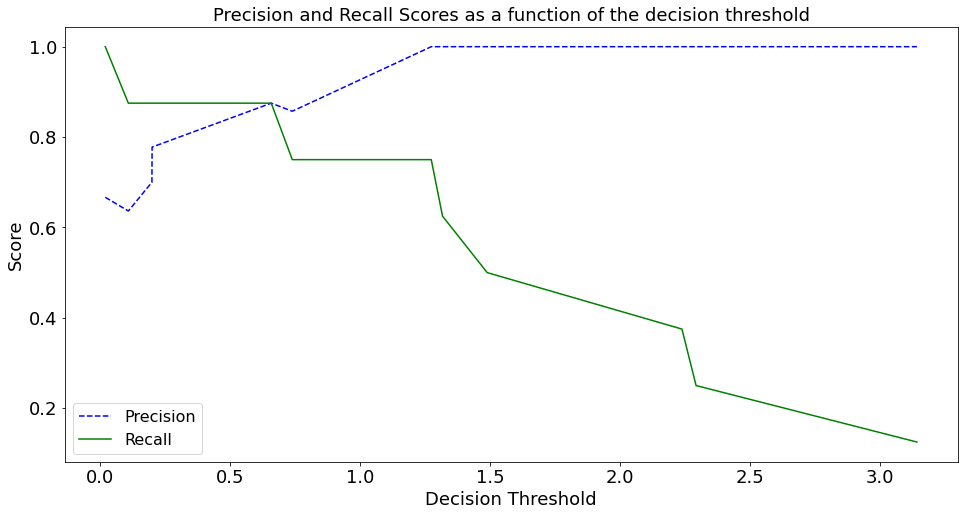

In [13]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    font = {'family' : 'Dejavu Sans',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(16, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Decision Threshold",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
    
# Calculate a "score" (a decision threshold)
try:
    # Get the index of the class that is "Broadband"
    positive_class_col = list(estimator.classes_).index(pos_label)
    scores = estimator.predict_proba(test_data['text'])[:, positive_class_col]
except AttributeError:
    scores = estimator.decision_function(test_data['text'])

precisions, recalls, thresholds = metrics.precision_recall_curve(test_data['label'], scores, pos_label=pos_label)    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## What are the chosen features and their coefficients?
With a little work, we can ask the pipeline what features it chose and what coefficients it assigned to those features. Intuitively, a positive coefficient means that the word belongs to Romeo and Juliet. A negative coefficient means that the word belongs to Moby Dick.

In [14]:
features = estimator.named_steps['vectorizer'].get_feature_names()
mask = estimator.named_steps['select'].get_support()
new_features = [ feature for bool, feature in zip (mask, features) if bool ]
nf = pd.DataFrame({'features': new_features, 'coef': estimator.named_steps['classifier'].coef_[0] })
nf.sort_values(['coef'], ascending=0)

,features,coef
39,highway,3.718185
98,vessel,3.170629
42,improvement,2.989121
92,transportation,2.589548
51,marad,2.578469
...,...,...
35,governments,-0.556874
32,fra,-0.835080
11,construction,-1.276399
79,safety,-1.656616


# Let's try parameter tuning

In [15]:
param_dist = {
      "vectorizer__ngram_range":[(1,1), (1,2)],
      "select__k":[10,50,100,200,500,1000,1500],
      "classifier__loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
}

pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
          ('select', SelectKBest()),
          ('classifier', SGDClassifier())])

#search = RandomizedSearchCV(pipe, 
#                                   param_distributions = param_dist,
#                                   n_iter = 500,
#                                   cv = 5,
#                                   n_jobs = -1,
#                                   verbose = 1)

search = GridSearchCV(pipe, 
                      param_grid = param_dist,
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)


search.fit(training_data['text'],training_data['label']);
estimator = search.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   10.4s finished


In [16]:
# So what parameters did it choose?
search.best_params_

{'classifier__loss': 'modified_huber',
 'select__k': 1500,
 'vectorizer__ngram_range': (1, 2)}

In [17]:
pred = estimator.predict(training_data['text'])
print(metrics.classification_report(training_data['label'],pred))

                               precision    recall  f1-score   support

                        Other       1.00      1.00      1.00       534
Transportation Infrastructure       1.00      1.00      1.00        34

                     accuracy                           1.00       568
                    macro avg       1.00      1.00      1.00       568
                 weighted avg       1.00      1.00      1.00       568



In [18]:
pred = estimator.predict(test_data['text'])
print(metrics.classification_report(test_data['label'],pred))

                               precision    recall  f1-score   support

                        Other       1.00      0.99      1.00       135
Transportation Infrastructure       0.89      1.00      0.94         8

                     accuracy                           0.99       143
                    macro avg       0.94      1.00      0.97       143
                 weighted avg       0.99      0.99      0.99       143



In [19]:
features = estimator.named_steps['vectorizer'].get_feature_names()
mask = estimator.named_steps['select'].get_support()
new_features = [ feature for bool, feature in zip (mask, features) if bool ]
nf = pd.DataFrame({'features': new_features, 'coef': estimator.named_steps['classifier'].coef_[0] })
nf.sort_values(['coef'], ascending=0)

,features,coef
647,highway,3.434113
658,highway projects,2.841871
804,lono,2.553484
1418,transportation,2.433357
338,department transportation,2.182727
...,...,...
384,educational institution,-1.493586
997,private educational,-1.493586
1191,research,-1.565162
894,nonprofit,-1.654213


In [20]:
search.best_score_

0.9911970190964137